In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. Cargar los datos
ruta_al_archivo = 'datos_sin_normalizar.csv'  # Modificar según la ubicación del archivo
data = pd.read_csv(ruta_al_archivo)

In [4]:
data.head()

,Unnamed: 0,id,genero,casado,edad,graduado,profesion,exp_laboral,nivel_gasto,tamanno_familia,anno_nacimiento,generacion,ingresos_anuales,provincia,encuentro_digital,gasto_medio_mensual_cuota,abandono,dias_como_cliente,camp_anno
0,0,CLI2,1,0,24,0,3,0,0,4,2000,2,13945,28,1.029,30,0,278,0.0
1,1,CLI3,0,1,42,1,4,2,1,3,1982,3,118107,35,1.790,30,0,455,3.0
2,2,CLI4,0,1,74,1,4,2,0,1,1950,1,53533,6,1.326,50,0,380,1.0
3,3,CLI5,1,1,74,1,8,2,2,2,1950,1,82273,14,0.779,50,1,387,3.0
4,4,CLI6,0,1,44,1,7,2,2,6,1980,1,90776,49,1.767,30,1,299,0.0


In [6]:
# 3. Selección de características
X = data.drop(columns=['id'])
#X = data

In [7]:
# 4. Determinación del número óptimo de clusters
wcss = []
silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

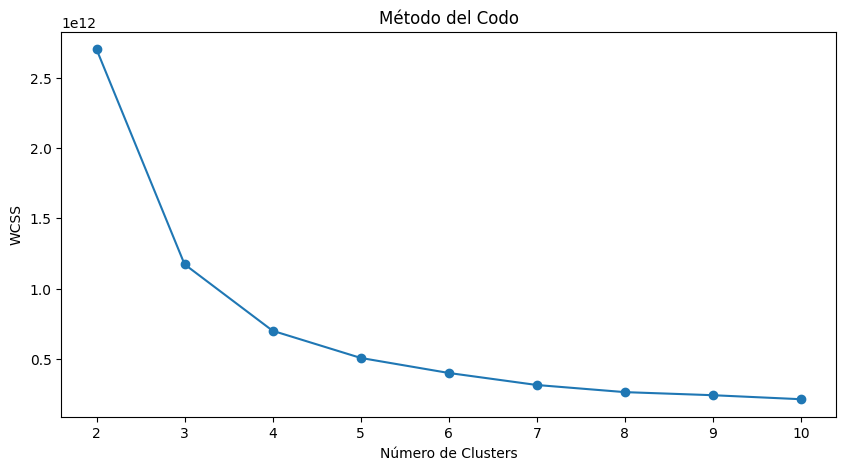

In [8]:
# Método del codo
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

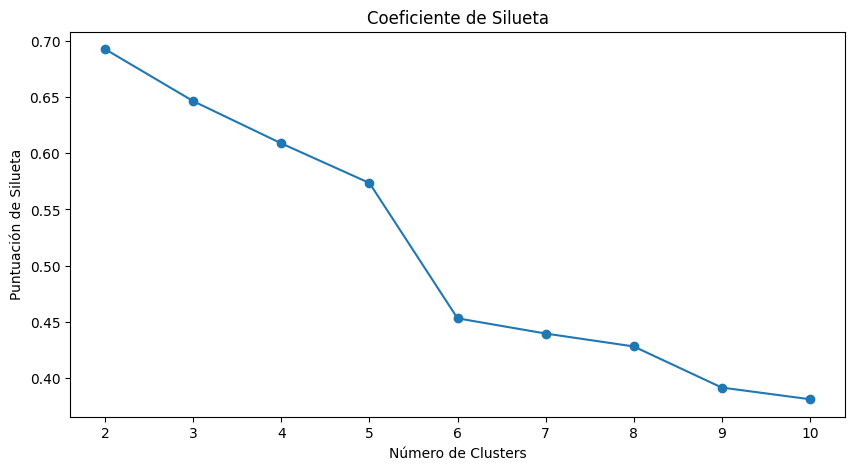

In [9]:
# Coeficiente de silueta
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta')
plt.show()

In [10]:
# Seleccionar el número óptimo de clusters (ajustar según los gráficos)
n_clusters_optimo = 6

In [11]:
# 5. Entrenamiento del modelo K-Means
kmeans = KMeans(n_clusters=n_clusters_optimo, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

In [12]:
# 6. Validación del modelo
# 1. Coeficiente de Silueta
silhouette_avg = silhouette_score(X, data['Cluster'])
print(f'Coeficiente de Silueta Promedio: {silhouette_avg:.2f}')

# 2. Índice Calinski-Harabasz
calinski_score = calinski_harabasz_score(X, data['Cluster'])
print(f'Índice de Calinski-Harabasz: {calinski_score:.2f}')

# 3. Índice Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, data['Cluster'])
print(f'Índice Davies-Bouldin: {davies_bouldin:.2f}')

# 4. Distancia Intra-cluster
clusters = data['Cluster'].unique()
intra_cluster_distances = {}

for cluster in clusters:
    cluster_data = X[data['Cluster'] == cluster]
    centroid = cluster_data.mean(axis=0)
    distances = np.linalg.norm(cluster_data - centroid, axis=1)
    intra_cluster_distances[cluster] = distances.mean()

print("\nDistancia promedio Intra-cluster (cohesión):")
for cluster, distance in intra_cluster_distances.items():
    print(f'Cluster {cluster}: {distance:.4f}')


Coeficiente de Silueta Promedio: 0.45
Índice de Calinski-Harabasz: 71549.49
Índice Davies-Bouldin: 0.68

Distancia promedio Intra-cluster (cohesión):
Cluster 1: 4233.7360
Cluster 2: 6540.5765
Cluster 3: 6443.7734
Cluster 0: 6414.2331
Cluster 4: 6487.3035
Cluster 5: 4812.5506


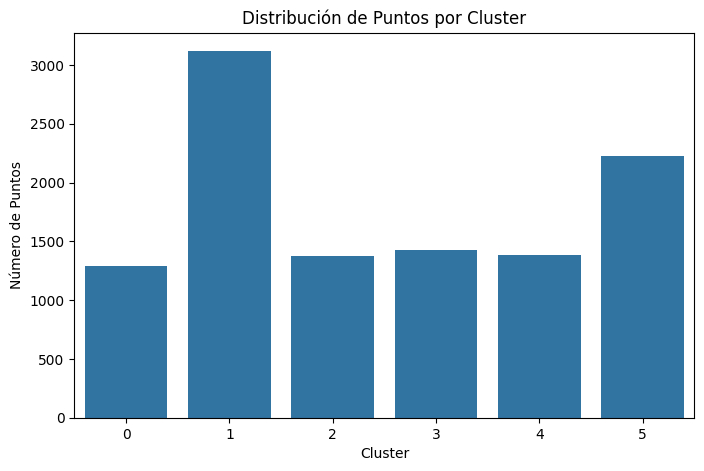

In [13]:
# Distribución de clusters
cluster_counts = data['Cluster'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Distribución de Puntos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Puntos')
plt.show()

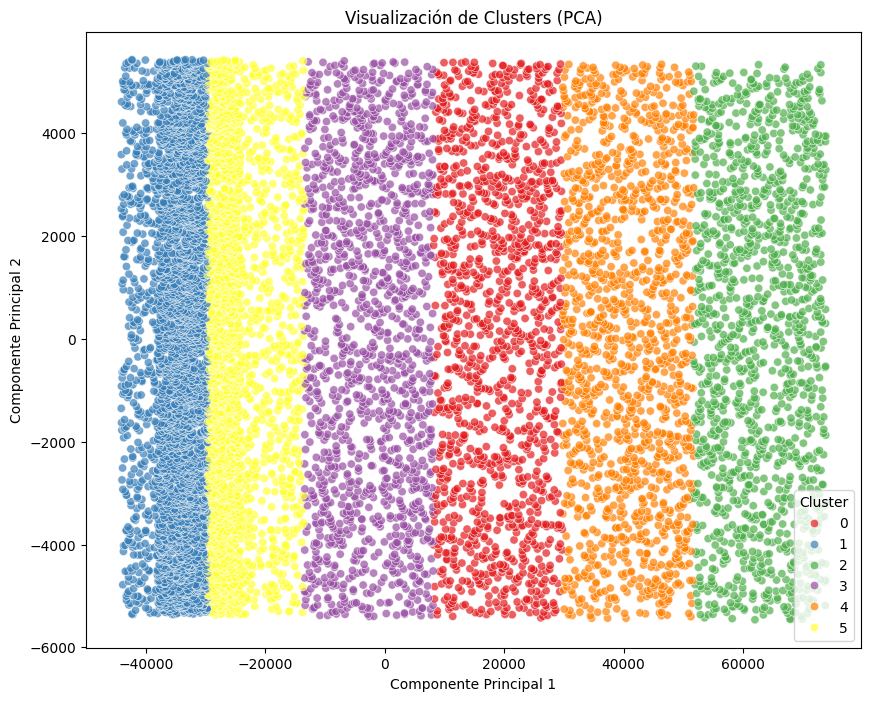

In [14]:
# 7. Visualización con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
data['PCA1'], data['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('Visualización de Clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [15]:
# 8. Gráfico de Siluetas
def plot_silhouette(X, labels, n_clusters):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower, y_upper = 0, 0
    yticks = []

    plt.figure(figsize=(10, 7))
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        yticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, [f'Cluster {i}' for i in range(n_clusters)])
    plt.ylabel("Clusters")
    plt.xlabel("Coeficiente de Silueta")
    plt.title("Gráfico de Silueta")
    plt.show()

In [ ]:
# Graficar siluetas
plot_silhouette(X, data['Cluster'].values, n_clusters_optimo)